**Import the libraries**

In [3]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix

In [4]:
train_data = r"./chest_xray/train" # Path of my training dataset
valid_data = r"./chest_xray/val"
test_data = r"./chest_xray/test"

**Need to set up the path**

In [5]:
path = Path(train_data)

# To list the contents of the library
contents = list(path.glob('*')) # List all files and the directories

'''
Additionally, we can use the len(contents) command to count the number of files in the folder.
'''
for item in contents:
    print(item)

chest_xray/train/NORMAL
chest_xray/train/PNEUMONIA


**Load the data for the training**

In [6]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image
    transforms.ToTensor(), # Convert images to the pytorch tensors
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [7]:
# Load the data using the ImageFolder
train_dataset = datasets.ImageFolder(root = train_data, transform = transform)

# Create a DataLoader for the dataset
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 4)

In [8]:
# Loading Validation and test dataset

val_dataset = datasets.ImageFolder(root = valid_data, transform = transform)
test_dataset = datasets.ImageFolder(root = test_data, transform = transform)

# Create a DataLoader for the val and test dataset 
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 4)

**Data Exploration**

**Define the class names**

In [18]:
class_names = train_dataset.classes

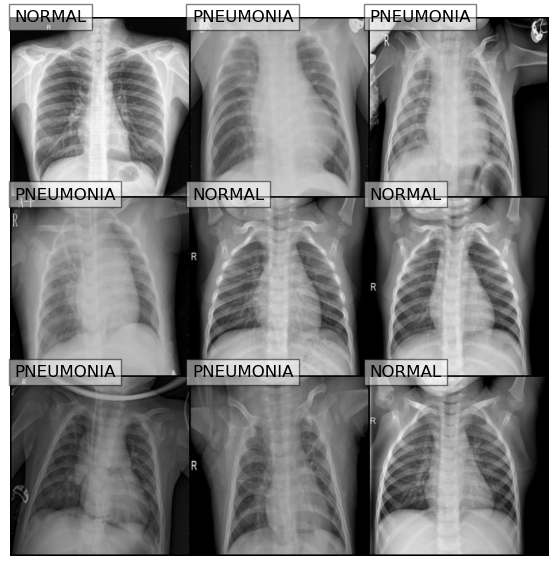

In [10]:
def imshow(img):
    img = img/2 + 0.5 # To unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from the tensor
    plt.axis('off') # Hide axis
    plt.show()

    for i in range(len(labels)):
        print(f"Label: {class_names[labels[i]]}")
    
    

# Get a batch of the training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Limit the number of images to display
num_images_to_display = min(9, len(images))
images = images[:num_images_to_display]
labels = labels[:num_images_to_display]

# Define unnormalize the images
def unnormalize(image, mean, std):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Unnormalize using the imagenet statistics
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# images = [unnormalize(image, mean, std) for image in images]
images = torch.stack([unnormalize(image, mean, std) for image in images])

# Create a grid from the batch
grid = make_grid(images, nrow = 3) # nrow = 3 for the 3 rows of the image

# Plot the image
plt.figure(figsize = (7, 7))
npimg = np.transpose(grid.numpy(), (1, 2, 0))
plt.imshow(npimg)
plt.axis('off')

batch_size = images.size(0)
for i in range(batch_size):
    label = class_names[labels[i]]
    plt.text(x = i % 3 * 224 + 5, y = i // 3 * 224 + 5, s = label, 
             color = 'black', fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5) )

plt.show()
    

**Using Machine Learning for the Pneumonia Detection**

**Load the pre-trained Res Net-50 model**

In [11]:
# model = models.resnet50(pretrained = True)
model = models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)

# Modify the finally fully connected layer to match the number of classes in your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # Since there are 2 features in our dataset

**Define the loss function and the optimizer**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

**Train the model**

In [13]:
num_epochs = 5 # Number of epochs to train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate the accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss/ len(train_loader.dataset)
    epoch_acc = 100 * correct/total
    print(f"Epoch {epoch+1}/ {num_epochs}, Loss: {epoch_loss: .4f}, Accuracy: {epoch_acc: .2f}%")

    # Validation Phase
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total
        print(f'Validation Loss: {val_loss : .4f}, Accuracy: {val_acc:.2f}%')

print('Finished Training')
        

Epoch 1/ 5, Loss:  0.1593, Accuracy:  94.38%
Validation Loss:  0.3505, Accuracy: 87.50%
Epoch 2/ 5, Loss:  0.0865, Accuracy:  96.74%
Validation Loss:  0.2534, Accuracy: 93.75%
Epoch 3/ 5, Loss:  0.0724, Accuracy:  97.16%
Validation Loss:  0.2595, Accuracy: 87.50%
Epoch 4/ 5, Loss:  0.0581, Accuracy:  97.81%
Validation Loss:  1.4828, Accuracy: 56.25%
Epoch 5/ 5, Loss:  0.0518, Accuracy:  98.08%
Validation Loss:  0.8272, Accuracy: 68.75%
Finished Training


**Save the trained model**

In [27]:
torch.save(model.state_dict(), 'resnet50_finetuned.pth')

**Generate Confusion Matrix**

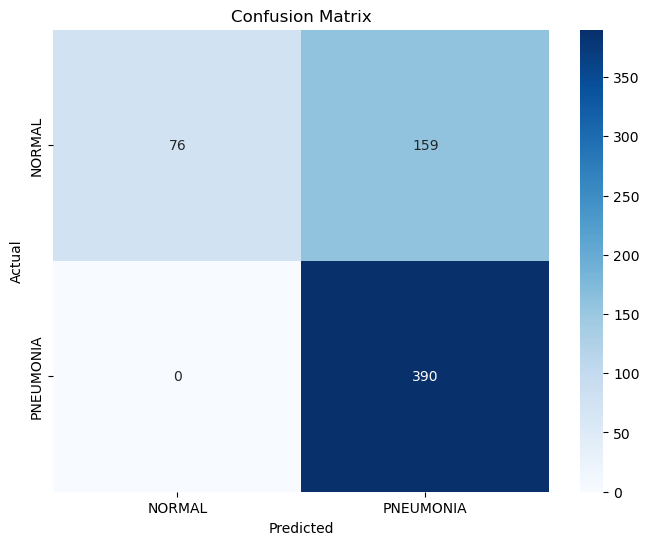

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

# set the model to the evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['NORMAL', 'PNEUMONIA'], yticklabels = ['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Predicting on a single image**

In [29]:
from PIL import Image

# Load the image
image_path = './chest_xray/test/NORMAL/IM-0001-0001.jpeg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
image = transform(image).unsqueeze(0) #Add the batch dimension

# Move the image to the same device as the model
image = image.to(device)

# Make a prediction
model.eval()
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Decode the prediction
class_names = ['Normal', 'Pneumonia']
print(f"Predicted: {class_names[predicted.item()]}")

Predicted: Pneumonia


In [32]:
# My Learning
print("Take aways")

'''
1. We can set the path manually, its easy. But if we want list the conent of the directory, we need to import the pathlib library.

2. When we do not have seprate training and validation datasets
from torch.utils.data import random_split

# Define the lengths for training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

3. We have achieved 74.56 % accuracy on the test data set using the training+validation approach.
'''
print(" ")

Take aways
 
